# COVID-19 

In this notebook we will go through the developments around the COVID-19 virus infections. First we look at the developments worldwide and finally EU only.

The dataset which I use in this project is provided by the [`European Centre for Disease Prevention and Control (ECDC)`](https://www.ecdc.europa.eu/en/geographical-distribution-2019-ncov-cases)

* Author: Erfan Nariman
* Date: 10-03-2020
* GitHub: [erfannariman](github.com/ErfPy)

---

In [1]:
import pandas as pd
import os
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn')
pd.set_option('display.max_columns', None)

---

### data import

In [40]:
df = pd.read_excel(os.path.join('..', 'data', 'COVID-19-geographic-disbtribution-worldwide-2020-03-15.xls'))

df.shape

(5122, 7)

---

# Worldwide
Minus China, to get rid of the extreme values for our model later on

### data cleaning

In [41]:
# clean up column names
df.columns = df.columns.str.replace('DateRep', 'Date').str.replace('CountryExp', 'Country')

# convert Date column to datetime type
df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)

# we filter out China to get rid of the extreme values
china = df.query('Country.eq("China")').copy()
df = df.query('Country.ne("China")')

# replace name to Japan
df['Country'] = df['Country'].str.replace('Cases on an international conveyance Japan', 'Japan')

# print first 5 rows of dataframe
df.head()

,Date,Country,NewConfCases,NewDeaths,GeoId,Gaul1Nuts1,EU
0,2020-03-15,Afghanistan,3,0.0,AF,NaN,Non-EU/EEA
1,2020-03-11,Afghanistan,3,0.0,AF,NaN,Non-EU/EEA
2,2020-03-08,Afghanistan,3,0.0,AF,NaN,Non-EU/EEA
3,2020-03-02,Afghanistan,0,0.0,AF,NaN,Non-EU/EEA
4,2020-03-01,Afghanistan,0,0.0,AF,NaN,Non-EU/EEA


### exploratory data analysis (EDA)

In [42]:
# range of data in days
df['Date'].max() - df['Date'].min()

Timedelta('75 days 00:00:00')

In [43]:
# checking for missing days by resampling and checking for NaN
df.set_index('Date').resample('D').mean().isna().sum()

NewConfCases    0
NewDeaths       0
dtype: int64

### which countries had highest new confirmed cases on a day

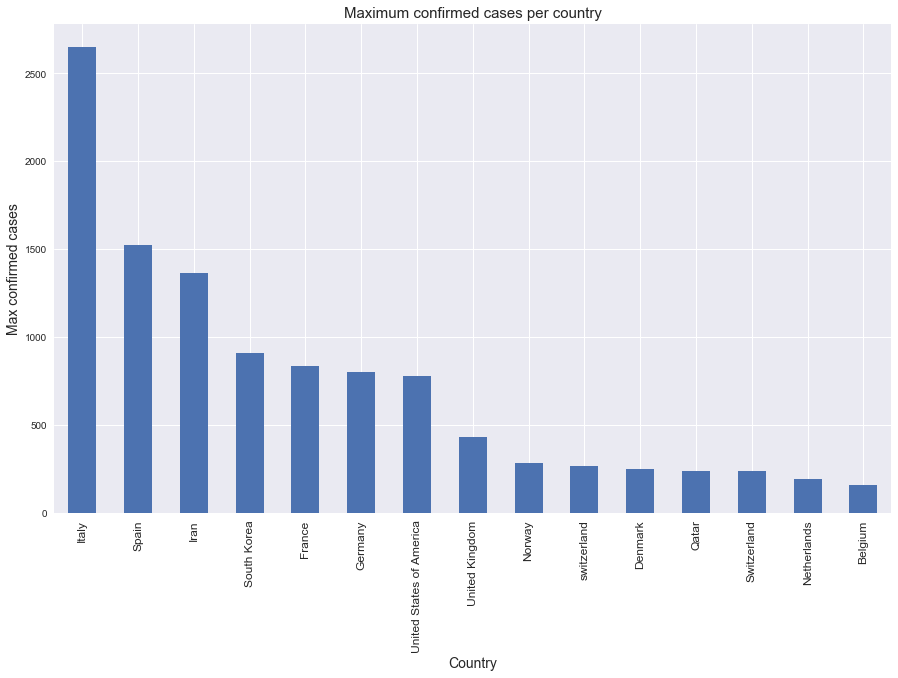

In [44]:
df.groupby('Country')['NewConfCases'].max().sort_values(ascending=False).head(15).plot(kind='bar', figsize=(15,9))
plt.xticks(size=12)
plt.ylabel('Max confirmed cases', size=14)
plt.xlabel('Country', size=14)
plt.title('Maximum confirmed cases per country', size=15)
plt.savefig('../plots/plt1.png', dpi=100)
plt.show()

### countries with highest total confirmed cases

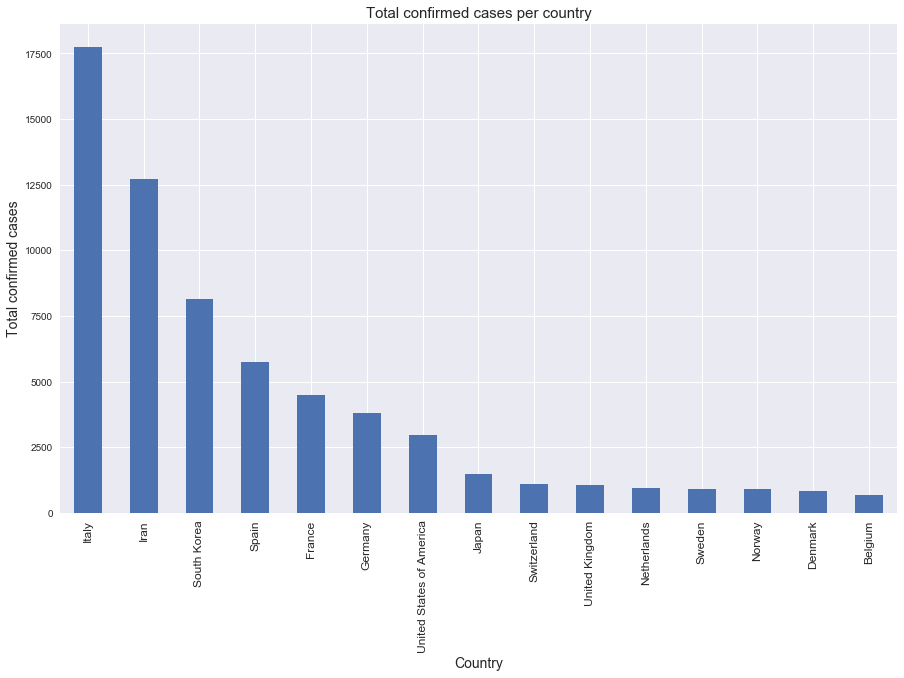

In [45]:
df.groupby('Country')['NewConfCases'].sum().sort_values(ascending=False).head(15).plot(kind='bar', figsize=(15,9))
plt.xticks(size=12)
plt.ylabel('Total confirmed cases', size=14)
plt.xlabel('Country', size=14)
plt.title('Total confirmed cases per country', size=15)
plt.savefig('../plots/plt2.png', dpi=100)
plt.show()

### cumulative sum of confirmed cases over time

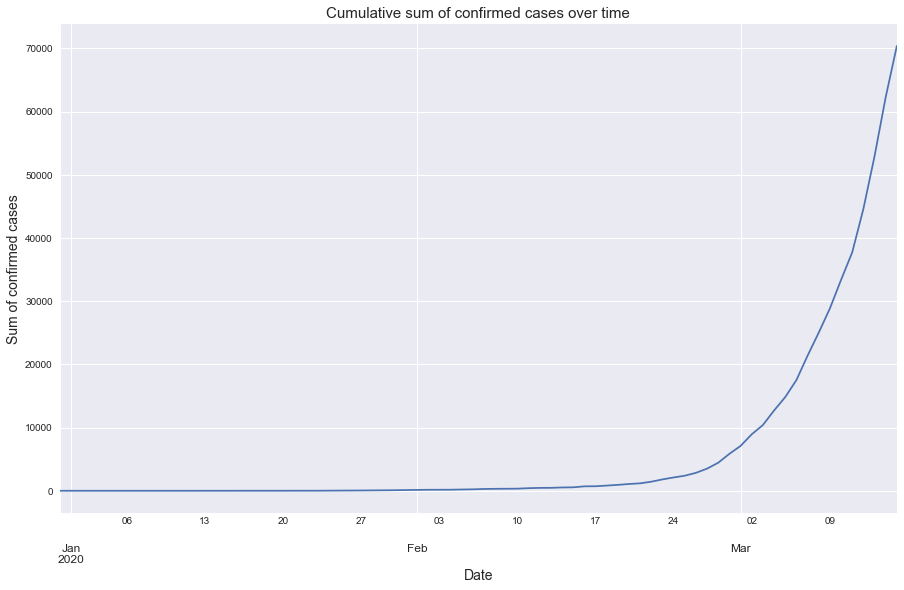

In [46]:
cases_cumsum = cases_sum.cumsum()
cases_cumsum.plot(figsize=(15,9))
plt.xticks(size=12)
plt.ylabel('Sum of confirmed cases', size=14)
plt.xlabel('Date', size=14)
plt.title('Cumulative sum of confirmed cases over time', size=15)
plt.savefig('../plots/plt3.png')
plt.show()

### The log of cumulative sum to check if growth is actually exponential

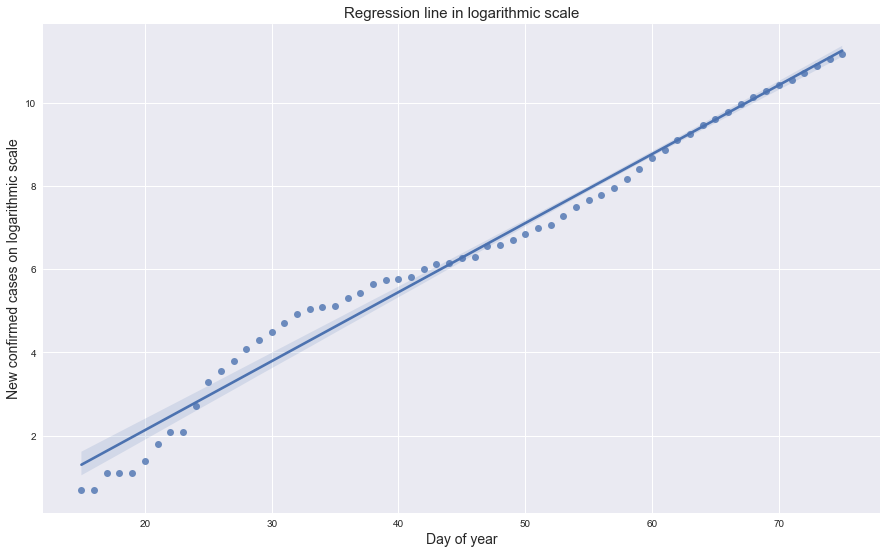

In [47]:
log_cumsum = np.log(cases_cumsum[cases_cumsum.gt(1)]).to_frame().reset_index()
log_cumsum['Date'] = log_cumsum['Date'].dt.dayofyear

plt.figure(figsize=(15,9))
plt.title("Regression line in logarithmic scale", size=15)
sns.regplot(x='Date', y='NewConfCases', data=log_cumsum)
plt.xlabel('Day of year', size=14)
plt.ylabel('New confirmed cases on logarithmic scale', size=14)
plt.savefig('../plots/plt4.png')
plt.show()

### fit a regression line through the log of confirmed cases, this way we can check R^2 

In [48]:
X = log_cumsum['Date']
y = log_cumsum['NewConfCases']

model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:           NewConfCases   R-squared (uncentered):                   0.993
Model:                            OLS   Adj. R-squared (uncentered):              0.993
Method:                 Least Squares   F-statistic:                              8086.
Date:                Sun, 15 Mar 2020   Prob (F-statistic):                    1.07e-65
Time:                        13:43:30   Log-Likelihood:                         -54.889
No. Observations:                  61   AIC:                                      111.8
Df Residuals:                      60   BIC:                                      113.9
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Date           0.1430      0.002     89.924      0.000       0.140       0.146
==============================================================================
Omnibus:                       15.658   Durbin-Watson:                   0.043
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               18.092
Skew:                          -1.292   Prob(JB):                     0.000118
Kurtosis:                       3.662   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### growth proportion per day, > 1 means we are still in an exponential growth

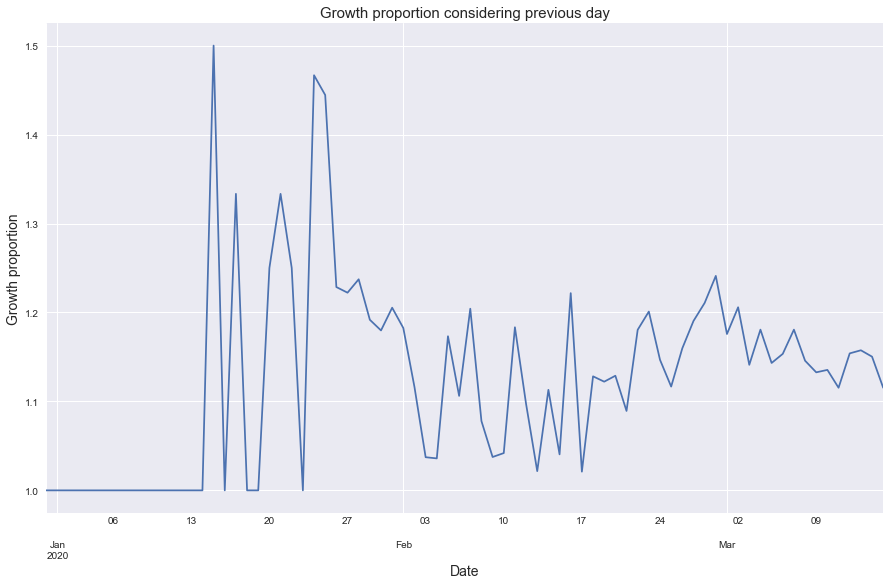

In [49]:
cases_cumsum = cases_cumsum.replace(0, 1)
cases_cumsum.diff().div(cases_cumsum).add(1).fillna(1).plot(figsize=(15,9))

plt.title('Growth proportion considering previous day', size=15)
plt.xlabel('Date', size=14)
plt.ylabel('Growth proportion', size=14)
plt.savefig('../plots/plt5.png')
plt.show()

### time series analysis

In [50]:
from itertools import product

p = d = q = range(0, 2)
pdq = list(product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(product(p, d, q))]

In [51]:
y = cases_cumsum
y.index = pd.DatetimeIndex(y.index.values,
                           freq=y.index.inferred_freq)

results_list = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            results_list.append((param, param_seasonal, results.aic))
            print(f'ARIMA{param}x{param_seasonal}12 - AIC:{results.aic}')
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1666.4265695197503
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1405.4523994795322
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1394.0391893482222
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1141.8930336332546
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1181.084102568278
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1140.1101574304105
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:991.1416582134324
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:967.6263117195092
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:1581.2192070698688
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1326.5344404484358
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1324.819659534915
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1070.8996258011198
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:1112.7713934920998


C:\Users\ErfanNarimanVeneficu\Anaconda3\envs\personal\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:1085.6826247246245
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:936.2121499649734


C:\Users\ErfanNarimanVeneficu\Anaconda3\envs\personal\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:906.4564357233753
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1355.4643550266223
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1167.5760573283321
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:1124.7188884503257
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:906.1820461514194
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:992.7295826509285
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:978.3024967629713
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:821.6482831493967
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:807.9025637800373
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:1256.7307542367626
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:1049.6014289323575
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:1042.7944699543966


C:\Users\ErfanNarimanVeneficu\Anaconda3\envs\personal\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\ErfanNarimanVeneficu\Anaconda3\envs\personal\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:892.8264645683864
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:996.7143370591455
ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:952.6126479188731
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:815.7713851517526
ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:786.121912480829
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:1104.108436761991
ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:958.8307769185735
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:931.7988811286617
ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:776.3795816627802
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:933.2157734833157
ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:934.9340243856042
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:766.4726506159383
ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:776.4242415981251
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:1090.6448684473467


C:\Users\ErfanNarimanVeneficu\Anaconda3\envs\personal\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:923.3178287511847
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:914.006655618759
ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:747.7486066651317
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:926.7372260727692
ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:914.6768712095999
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:761.0453737631931
ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:749.0918536565728
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:1107.5362057333143
ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:936.5038645135221
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:927.713727750098
ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:758.550238963822
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:926.9548790840511
ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:928.3668383536716
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:757.9340201910526
ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:759.8251865177623
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:1080.9787965271996
ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:911.9907702104516
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:907.7098298386244
ARIMA(1, 1,

In [52]:
min_aic = min([aic for x, y, aic in results_list if aic > 0])
for param, p_seasonal, aic in results_list:
    if aic == min_aic:
        p, p_s, a = param, p_seasonal, aic

print(p, p_s, a)

(1, 1, 1) (0, 1, 1, 12) 735.2903830044603


In [53]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=p,
                                seasonal_order=p_s,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1310      0.006    200.705      0.000       1.120       1.142
ma.L1         -0.8381      0.093     -9.058      0.000      -1.019      -0.657
ma.S.L12       0.5390      0.408      1.322      0.186      -0.260       1.338
sigma2      1.788e+05   2.53e+04      7.069      0.000    1.29e+05    2.28e+05


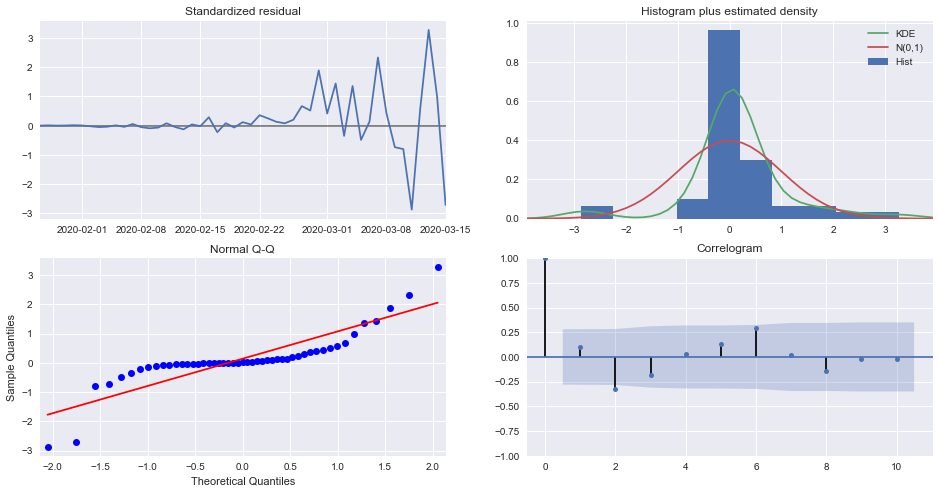

In [54]:
results.plot_diagnostics(figsize=(16, 8))
plt.savefig('../plots/plt6.png')
plt.show()

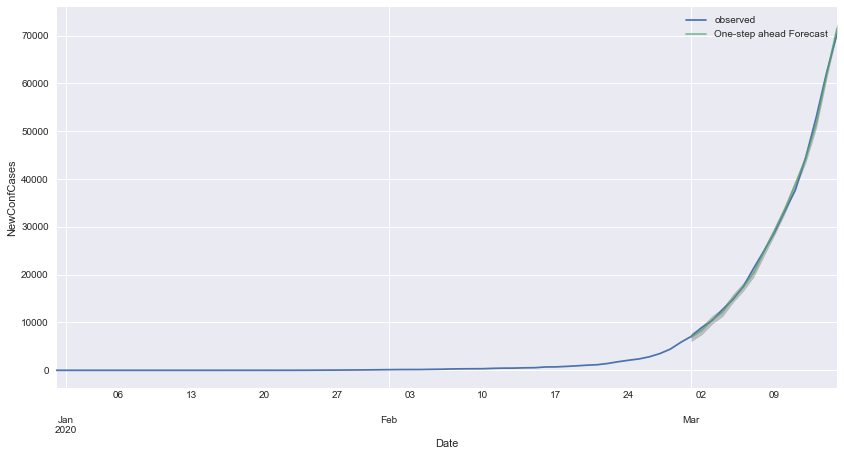

In [55]:
pred = results.get_prediction(start=(y.index.max() - pd.Timedelta(days=14)), dynamic=False)
pred_ci = pred.conf_int()
ax = y.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('NewConfCases')
plt.legend()
plt.savefig('../plots/plt7.png')
plt.show()

In [56]:
y_forecasted = pred.predicted_mean
y_truth = y[(y.index.max() - pd.Timedelta(days=14)):]
mse = ((y_forecasted - y_truth) ** 2).mean()
print(f'The Mean Squared Error of our forecasts is {round(mse, 2)}')

The Mean Squared Error of our forecasts is 464206.89


In [57]:
print(f'The Root Mean Squared Error of our forecasts is {round(np.sqrt(mse), 2)}')

The Root Mean Squared Error of our forecasts is 681.33


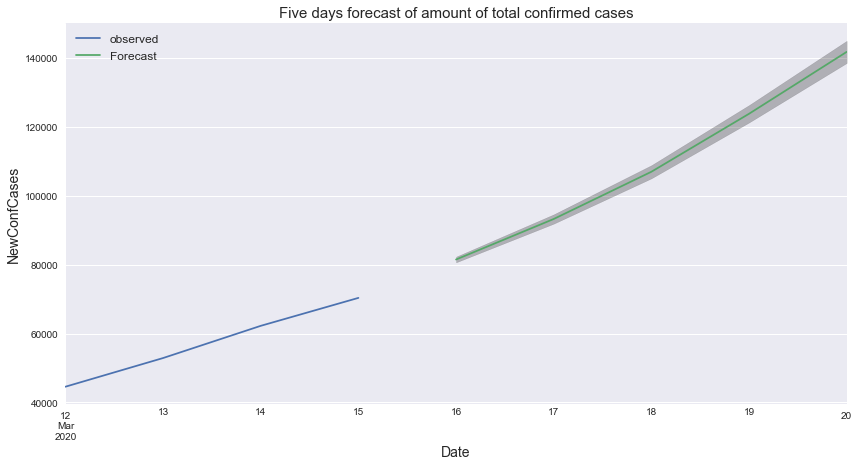

In [58]:
pred_uc = results.get_forecast(steps=5)
pred_ci = pred_uc.conf_int()
ax = y[(y.index.max() - pd.Timedelta(days=3)):].plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date', size=14)
ax.set_ylabel('NewConfCases', size=14)
plt.legend(fontsize=12)
plt.title('Five days forecast of amount of total confirmed cases', size=15)
plt.savefig('../plots/plt9.png')
plt.show()

# Netherlands

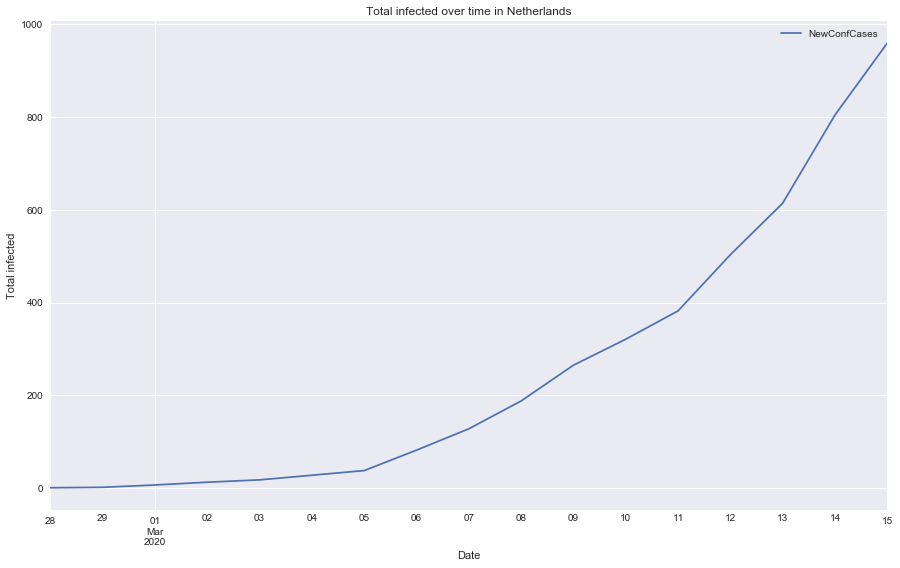

In [59]:
df.query('Country == "Netherlands" & NewConfCases > 0').loc[:, ['Date', 'NewConfCases']].set_index('Date').sort_index().cumsum().plot(figsize=(15,9))
plt.ylabel('Total infected')
plt.title('Total infected over time in Netherlands')
plt.savefig('../plots/NL1.png')
plt.show()

In [60]:
df.query('Country == "Netherlands" & NewConfCases > 0')

,Date,Country,NewConfCases,NewDeaths,GeoId,Gaul1Nuts1,EU
3257,2020-03-15,Netherlands,155,7.0,NL,NaN,EU
3258,2020-03-14,Netherlands,190,0.0,NL,NaN,EU
3259,2020-03-13,Netherlands,111,0.0,NL,NaN,EU
3260,2020-03-12,Netherlands,121,1.0,NL,NaN,EU
3261,2020-03-11,Netherlands,61,1.0,NL,NaN,EU
3262,2020-03-10,Netherlands,56,0.0,NL,NaN,EU
3263,2020-03-09,Netherlands,77,2.0,NL,NaN,EU
3264,2020-03-08,Netherlands,60,0.0,NL,NaN,EU
3265,2020-03-07,Netherlands,46,1.0,NL,NaN,EU
3266,2020-03-06,Netherlands,44,0.0,NL,NaN,EU


# China

In [33]:
china = china.set_index('Date').sort_index()

In [34]:
china.sort_index(ascending=False)

,Country,NewConfCases,NewDeaths,GeoId,Gaul1Nuts1,EU
Date,,,,,,
2020-03-13,China,22,7,CN,NaN,Non-EU/EEA
2020-03-12,China,24,11,CN,NaN,Non-EU/EEA
2020-03-11,China,29,22,CN,NaN,Non-EU/EEA
2020-03-10,China,20,17,CN,NaN,Non-EU/EEA
2020-03-09,China,45,23,CN,NaN,Non-EU/EEA
...,...,...,...,...,...,...
2020-01-04,China,0,0,CN,NaN,Non-EU/EEA
2020-01-03,China,17,0,CN,NaN,Non-EU/EEA
2020-01-02,China,0,0,CN,NaN,Non-EU/EEA


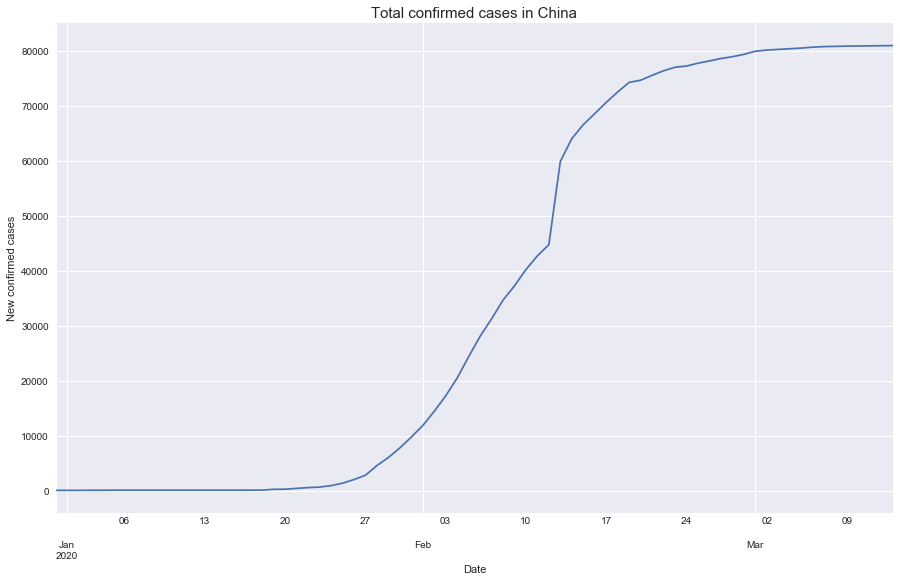

In [35]:
china['NewConfCases'].cumsum().plot(figsize=(15,9))
plt.ylabel('New confirmed cases')
plt.title('Total confirmed cases in China', size=15)
plt.savefig('../plots/china1.png')
plt.show()

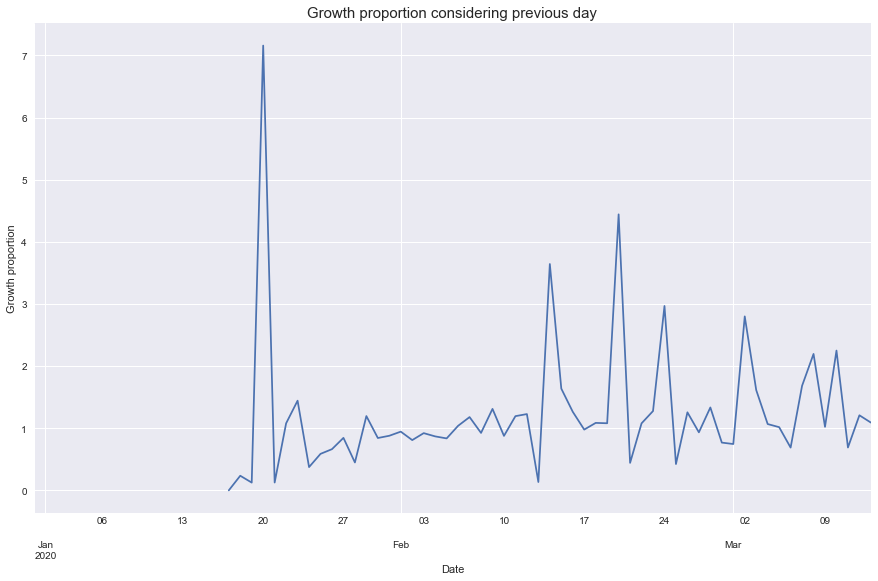

In [36]:
china['NewConfCases'].shift().div(china['NewConfCases']).plot(figsize=(15,9))
plt.ylabel('Growth proportion')
plt.title('Growth proportion considering previous day', size=15)
plt.savefig('../plots/china1.png')
plt.show()

---